<a href="https://colab.research.google.com/github/solobala/DSNN18/blob/main/Notebook_for_lecture_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лекция 2. Углубление в НС и библиотеку Keras


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

На прошлой лекции мы познакомились с базовым набором инструментов библиотеки Keras, научились строить модели с помощью инструмента ```keras.Sequential()```. Однако на практике не все модели удается реализовать с помощью этого метода.

Если в модели присутствует "нелинейная" структура (т.е. есть разветвление потока данных), то ```keras.Sequential()``` не подойдет для построения такой модели. На помощь приходит инструмент *functional API*.


Рассмотрим следующую модель:

<div class="k-default-codeblock">
```
(input: 784-dimensional vectors)
       ↧
[Dense (32 units, relu activation)]
       ↧
[Dense (32 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```
</div>

Обычно в глубоком обучении принято использовать следующую структуру во входных данных:

$$[n, N_{ch}, W,H],$$

где $n$ - размер подвыборки (batch_size), $N_{ch}$ - кол-во каналов (красный, зеленый, синий), $W$, $H$ - ширина и высота изображения. Однако batch_size не указывается при объявлении слоев в Keras.



In [ ]:
img_inputs = keras.Input(shape=(32, 32, 3)) # 2 скрытых слоя по 32 нейрона. К-во каналов =3
print(img_inputs.shape)

(None, 32, 32, 3)


На сегодняшний день мы пока забудем о вышеописанной структуре и будем все входные данные трактовать как один длинный вектор длины $(N_{ch}\cdot W \cdot H)$.

In [ ]:
inputs = keras.Input(shape=(784,)) # картинки 28х28 пикселей (всего 784) переделали в длинный вектор

In [ ]:
print("Shape of input is", inputs.shape)
print("Data type of input is", inputs.dtype)

Shape of input is (None, 784)
Data type of input is <dtype: 'float32'>


Следующий слой, который будет использовать тензор `inputs` как входные данные, должен быть объявлен следующим образом:


In [ ]:
# создадим ветвистую структуру с 2 ветвями Х и у ( на выходе сольются в 1)
x = layers.Dense(32)(inputs) ### объявление слоя
x = layers.BatchNormalization()(x) # нормализация для борьбы с затуханием и взрывом градиента ф-ии потерь
x = layers.Dropout(0.5)(x) # зануление половины веслв для борьбы с переобучением
x = layers.Activation('relu')(x) # ф-я активации - дает нелинейность

y = layers.Dense(32)(inputs)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.Activation('relu')(y)

# Добавим в обе ветви еще по 1 слою ( уже без нормализации и дропаутов)
dense21 = layers.Dense(32, activation="relu")(x)
dense22 = layers.Dense(32, activation='relu')(y)

dense3 = layers.Add()([dense21, dense22]) # т.е это третий слой в сети - сумма выходов dense21 и dense22

In [ ]:
x = layers.Dense(32, activation="relu")(dense3) # уже 4 слой с 32 нейронами на выходе
outputs = layers.Dense(10)(x) # выходной слой из 10 нейронов

На этом этапе мы можем закончить добавление новых блоков и объявить модель, которая будет состоять из данных слоёв:

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="our_second_model")

In [ ]:
model.summary()

Model: "our_second_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           25120       ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           25120       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32)          128         ['dense[0][0]']                  
 alization)                                                                        

Можно, например, нарисовать модель в виде направленного графа:

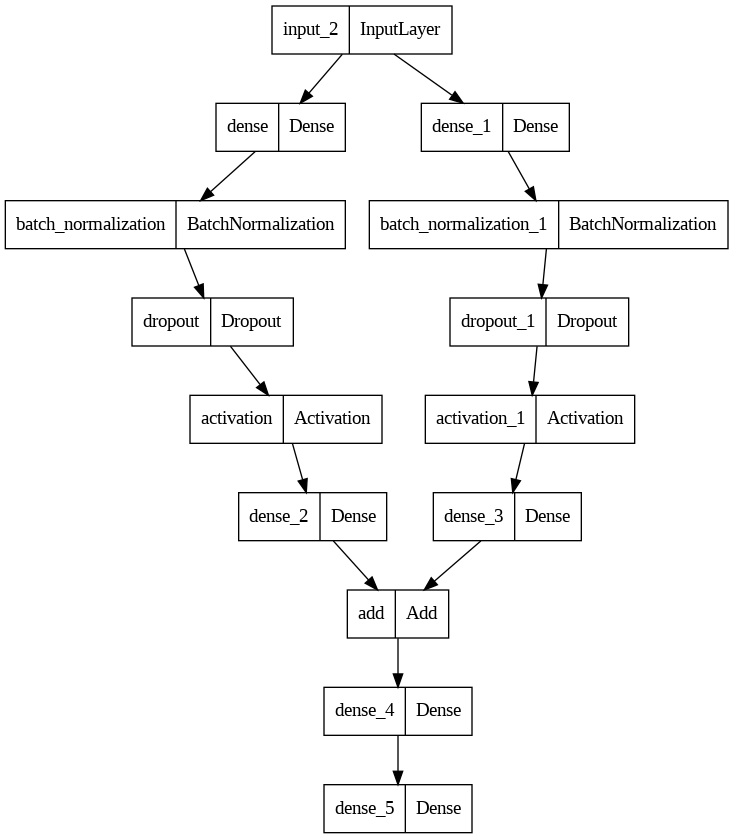

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

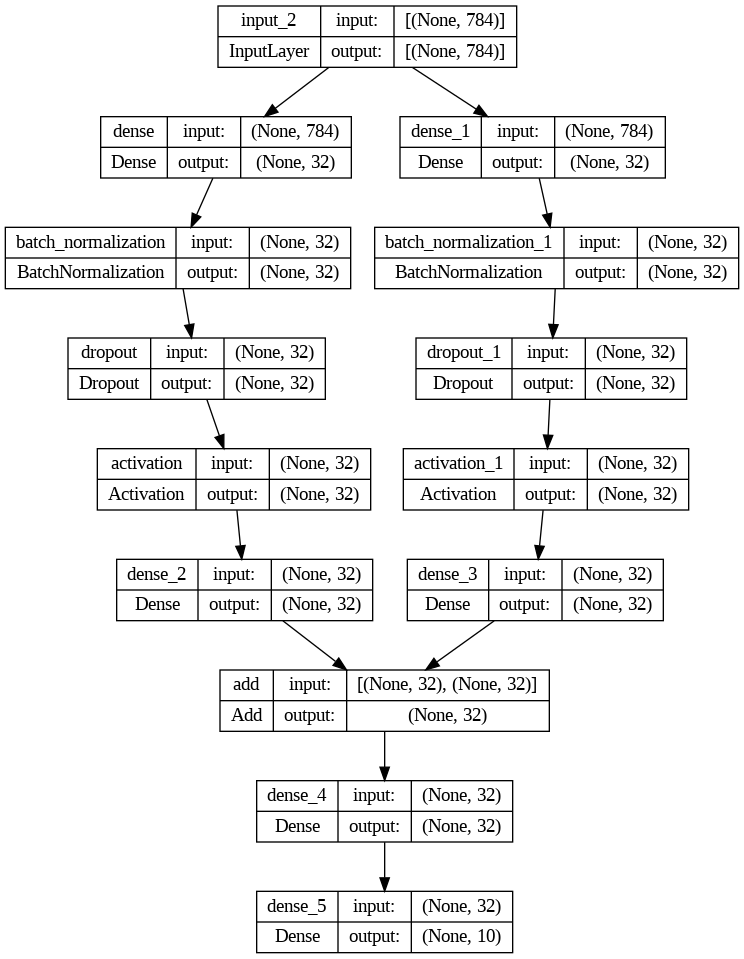

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True) # Можног сохранить как png картинку и скачать ее

## Обучение модели

Обучение модели происходит тем же самым образом, что и модели, объявленной с помощью класса ```Sequential()```, т.е. с помощью метода ```fit()```.


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() # загрузили и сразу разбили на train и test. А как в обучных случаях, когда свой датасет, разбивать?

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
y_train.shape

(60000,)

In [ ]:
# Нормируем данные ( каждый пиксель кодируется от 0 до 255, поэтому делим на 255)
x_train = x_train.reshape(60000, 784).astype("float32") / 255.
x_test = x_test.reshape(10000, 784).astype("float32") / 255.
# Здесь прописываем ф-ю потерь для разреженных матриц Sparse() loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# мы в модели на выходном слое не задали ф-ю активации softmax для мультиклассов, поэтому в ф-ю потерь пишем from_logits=True)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), ### ОТЛИЧИЕ_ОТ_CategoricalCrossEntropy
    # У нас размерность y 60000, Onehot кодировку не используем ( если бы использовали, то ф-я потерь была бы CategoricalCrossEntropy)
    optimizer=keras.optimizers.RMSprop(), # Выбираем оптимизатор
    metrics=["accuracy"], # и метрики ( здесь нет дисбаланса, можно accuracy)
)

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2) # обучение - как мы выбрали batch_size и кол-во эпох?

test_scores = model.evaluate(x_test, y_test, verbose=2) # Проверка на тестовой выборке
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
750/750 [==============================] - 12s 6ms/step - loss: 0.6507 - accuracy: 0.7981 - val_loss: 0.2351 - val_accuracy: 0.9298
Epoch 2/10
750/750 [==============================] - 3s 5ms/step - loss: 0.4055 - accuracy: 0.8769 - val_loss: 0.1946 - val_accuracy: 0.9433
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 0.3555 - accuracy: 0.8929 - val_loss: 0.1873 - val_accuracy: 0.9469
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 0.3299 - accuracy: 0.8989 - val_loss: 0.1626 - val_accuracy: 0.9540
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 0.3121 - accuracy: 0.9054 - val_loss: 0.1603 - val_accuracy: 0.9536
Epoch 6/10
750/750 [==============================] - 4s 5ms/step - loss: 0.2993 - accuracy: 0.9091 - val_loss: 0.1466 - val_accuracy: 0.9592
Epoch 7/10
750/750 [==============================] - 5s 7ms/step - loss: 0.2894 - accuracy: 0.9124 - val_loss: 0.1492 - val_accuracy: 0.9573
Epoch

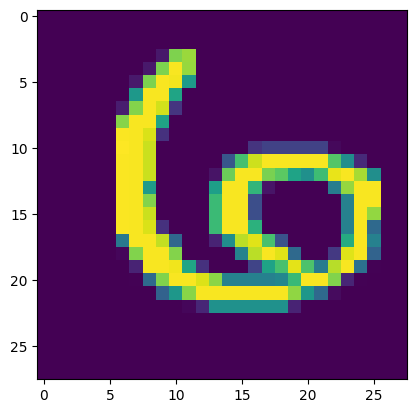

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_test[54].reshape(28,28))

## Сохранение модели

 `model.save()` при вызове сохраняет модель в один файл.
Сохраненный файл включает в себя:
- архитектуру модели;
- веса модели;
- config-file (если такой был создан при компиляции);
- оптимизатор и его состояние.

In [ ]:
model.save("path_to_my_model")
del model

In [ ]:
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

In [ ]:
model.summary()

Model: "our_second_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           25120       ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           25120       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32)          128         ['dense[0][0]']                  
 alization)                                                                        

In [ ]:
import pandas as pd
list1 =[1,2,3]
list2=[4,5,6]

In [ ]:
d =[{'points': 50, 'time': '5:00', 'year': 2010}, {'points': 25, 'time': '6:00', 'month': "february"}, {'points':90, 'time': '9:00', 'month': 'january'}, {'points_h1':20, 'month': 'june'}]

In [ ]:
df = pd.DataFrame(d)
df[['points', 'time']]

,points,time
0,50.0,5:00
1,25.0,6:00
2,90.0,9:00
3,NaN,NaN
